In [2]:
from google.colab import drive


drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Dataset Initialization**

In [3]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class HeartDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform

        self.images = sorted(os.listdir(images_dir))
        self.masks = sorted(os.listdir(masks_dir))

        self.image_mask_pairs = self.match_images_and_masks()
        print(f"Matched {len(self.image_mask_pairs)} image-mask pairs.")

    def match_images_and_masks(self):
        pairs = []
        for image in self.images:
            image_base = image.replace('CT_', 'gold_').replace('.jpg', '.png')
            mask = next((m for m in self.masks if m == image_base), None)
            if mask:
                pairs.append((image, mask))
            else:
                print(f"No mask found for image {image}")
        return pairs

    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        image_filename, mask_filename = self.image_mask_pairs[idx]
        img_path = os.path.join(self.images_dir, image_filename)
        mask_path = os.path.join(self.masks_dir, mask_filename)

        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        mask = (mask > 0).float()
        return image, mask


data_path = '/content/gdrive/My Drive/Heart'
train_images_dir = os.path.join(data_path, 'images/tr')
val_images_dir = os.path.join(data_path, 'images/val')
test_images_dir = os.path.join(data_path, 'images/ts')
masks_dir = os.path.join(data_path, 'golds')

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = HeartDataset(train_images_dir, masks_dir, transform)
val_dataset = HeartDataset(val_images_dir, masks_dir, transform)
test_dataset = HeartDataset(test_images_dir, masks_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))
print("Number of test samples:", len(test_dataset))


Matched 119 image-mask pairs.
Matched 56 image-mask pairs.
Matched 82 image-mask pairs.
Number of training samples: 119
Number of validation samples: 56
Number of test samples: 82


# **PART 1 NETWORK CONSTRUCTION**

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, init_features=16):
        super(UNet, self).__init__()
        features = init_features
        self.encoder1 = UNet._block(in_channels, features)
        self.encoder2 = UNet._block(features, features * 2)
        self.encoder3 = UNet._block(features * 2, features * 4)
        self.encoder4 = UNet._block(features * 4, features * 8)

        self.bottleneck = UNet._block(features * 8, features * 16)

        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = UNet._block(features * 16, features * 8)
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = UNet._block(features * 8, features * 4)
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = UNet._block(features * 4, features * 2)
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = UNet._block(features * 2, features)

        self.conv = nn.Conv2d(features, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, 2))
        enc3 = self.encoder3(F.max_pool2d(enc2, 2))
        enc4 = self.encoder4(F.max_pool2d(enc3, 2))

        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features):
        return nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True)
        )

model = UNet(in_channels=1, out_channels=1)
print(model)


UNet(
  (encoder1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1

In [17]:
import torch.optim as optim
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, device='cuda'):
    best_model_wts = model.state_dict()
    best_score = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, masks in train_loader:
            inputs, masks = inputs.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        val_loss, val_fscore, val_precision, val_recall = evaluate_model(model, val_loader, criterion, device)

        print(f"Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F-score: {val_fscore:.4f}")

        if val_fscore > best_score:
            best_score = val_fscore
            best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)
    return model, best_score


def evaluate_model(model, data_loader, criterion, device='cuda'):
    model.eval()
    running_loss = 0.0
    all_outputs = []
    all_masks = []

    with torch.no_grad():
        for inputs, masks in data_loader:
            inputs, masks = inputs.to(device), masks.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, masks)
            running_loss += loss.item() * inputs.size(0)

            all_outputs.append(outputs.cpu())
            all_masks.append(masks.cpu())

    epoch_loss = running_loss / len(data_loader.dataset)

    outputs = torch.cat(all_outputs)
    masks = torch.cat(all_masks)

    precision, recall, fscore = calculate_metrics(outputs, masks)

    return epoch_loss, fscore, precision, recall

def calculate_metrics(outputs, masks, threshold=0.5):
    preds = outputs > threshold
    masks = masks > threshold

    tp = (preds & masks).sum().item()
    fp = (preds & ~masks).sum().item()
    fn = (~preds & masks).sum().item()

    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)
    fscore = 2 * precision * recall / (precision + recall + 1e-7)

    print("precision: ", precision)
    print("recall: ", recall)
    print("fscore: ", fscore)

    return precision, recall, fscore
def visualize_predictions(model, data_loader, device='cuda'):
    model.eval()
    all_outputs = []
    all_masks = []
    all_inputs = []

    with torch.no_grad():
        for inputs, masks in data_loader:
            inputs, masks = inputs.to(device), masks.to(device)
            outputs = model(inputs)
            all_inputs.append(inputs.cpu())
            all_outputs.append(outputs.cpu())
            all_masks.append(masks.cpu())

    inputs = torch.cat(all_inputs)
    outputs = torch.cat(all_outputs)
    masks = torch.cat(all_masks)

    return inputs,outputs,masks

def plot_segmentation_results(inputs, outputs, masks, indices, title, save_path):
    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(indices):
        plt.subplot(3, len(indices), i + 1)
        plt.title(f"{title} Input {idx}")
        plt.imshow(inputs[idx].squeeze(), cmap='gray')

        plt.subplot(3, len(indices), i + 1 + len(indices))
        plt.title(f"{title} Output {idx}")
        plt.imshow(outputs[idx].squeeze(), cmap='gray')

        plt.subplot(3, len(indices), i + 1 + 2 * len(indices))
        plt.title(f"{title} Mask {idx}")
        plt.imshow(masks[idx].squeeze(), cmap='gray')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

def calculate_metrics_per_sample(outputs, masks, threshold=0.5):
    preds = outputs > threshold
    masks = masks > threshold

    tp = (preds & masks).sum(dim=(1, 2, 3)).float()
    fp = (preds & ~masks).sum(dim=(1, 2, 3)).float()
    fn = (~preds & masks).sum(dim=(1, 2, 3)).float()

    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)
    fscore = 2 * precision * recall / (precision + recall + 1e-7)

    return precision, recall, fscore




precision:  0.8874570285346932
recall:  0.8220493188821661
fscore:  0.8535018360960185
Epoch 0/24, Loss: 0.3608, Val Loss: 0.3747, Val Precision: 0.8875, Val Recall: 0.8220, Val F-score: 0.8535
precision:  0.9057571757611556
recall:  0.8426369692749223
fscore:  0.873057645493044
Epoch 1/24, Loss: 0.3564, Val Loss: 0.3655, Val Precision: 0.9058, Val Recall: 0.8426, Val F-score: 0.8731
precision:  0.8942753983743779
recall:  0.8712115939144697
fscore:  0.8825927967631628
Epoch 2/24, Loss: 0.3520, Val Loss: 0.3648, Val Precision: 0.8943, Val Recall: 0.8712, Val F-score: 0.8826
precision:  0.892660789734262
recall:  0.8508103808290617
fscore:  0.8712332451794117
Epoch 3/24, Loss: 0.3480, Val Loss: 0.3621, Val Precision: 0.8927, Val Recall: 0.8508, Val F-score: 0.8712
precision:  0.8637392353654612
recall:  0.8860992343639043
fscore:  0.8747763232419451
Epoch 4/24, Loss: 0.3437, Val Loss: 0.3587, Val Precision: 0.8637, Val Recall: 0.8861, Val F-score: 0.8748
precision:  0.8844641114005928
r

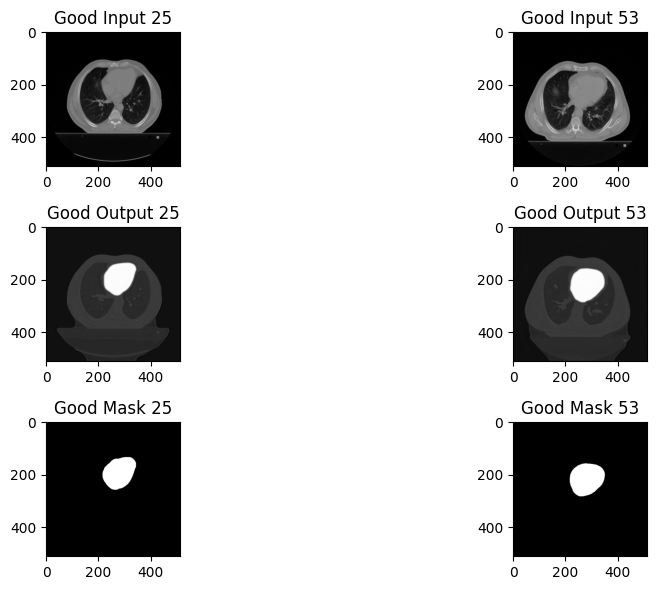

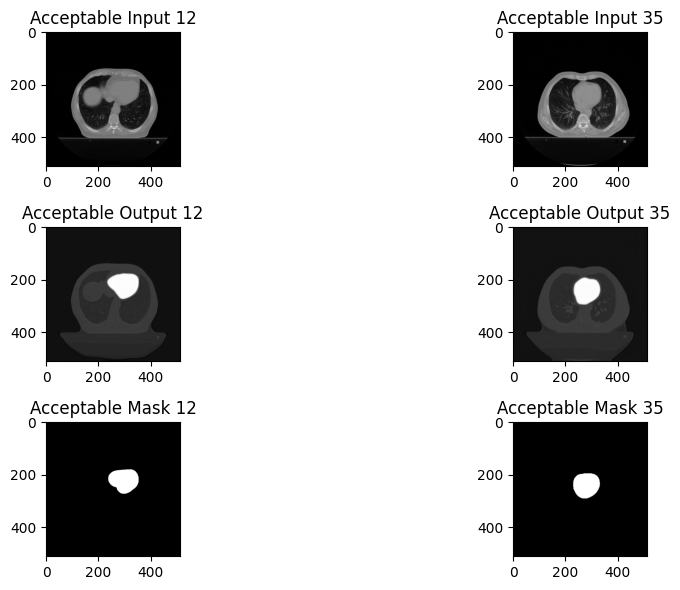

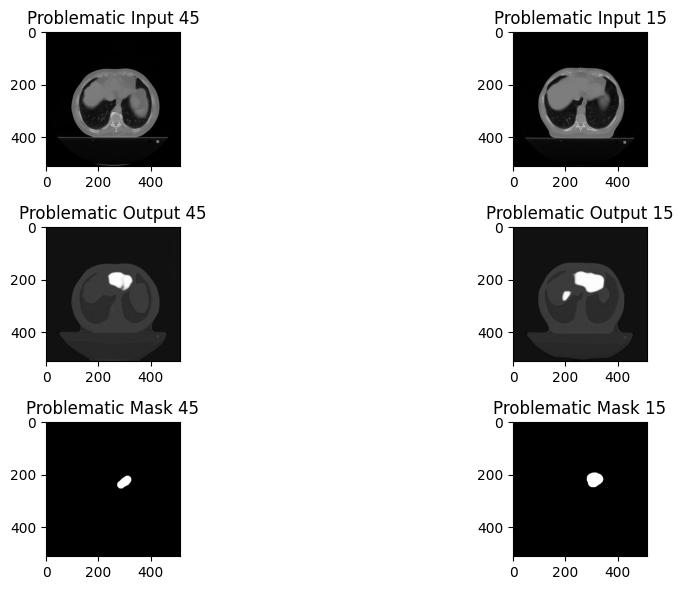

In [18]:
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train the model
best_model, best_val_score = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, device='cuda')

# Evaluate on test set
test_loss, test_fscore, test_precision, test_recall = evaluate_model(best_model, test_loader, criterion, device='cuda')
print(f"Test Loss: {test_loss:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F-score: {test_fscore:.4f}")

# Calculate pixel-level metrics for each test sample and average them
inputs, outputs, masks = visualize_predictions(best_model, test_loader, device='cuda')
precision, recall, fscores = calculate_metrics_per_sample(outputs, masks)
overall_precision = precision.mean().item()
overall_recall = recall.mean().item()
overall_fscore = fscores.mean().item()

print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")
print(f"Overall F-score: {overall_fscore:.4f}")

# Evaluate on training set for metrics
train_loss, train_fscore, train_precision, train_recall = evaluate_model(best_model, train_loader, criterion, device='cuda')
print(f"Training Loss: {train_loss:.4f}, Training Precision: {train_precision:.4f}, Training Recall: {train_recall:.4f}, Training F-score: {train_fscore:.4f}")

# Evaluate on validation set for metrics
val_loss, val_fscore, val_precision, val_recall = evaluate_model(best_model, val_loader, criterion, device='cuda')
print(f"Validation Loss: {val_loss:.4f}, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}, Validation F-score: {val_fscore:.4f}")

# Select indices for good, acceptable, and problematic results
sorted_indices = np.argsort(fscores)
good_indices = sorted_indices[-2:]
acceptable_indices = sorted_indices[len(sorted_indices)//2 - 1:len(sorted_indices)//2 + 1]
problematic_indices = sorted_indices[:2]

# Plot and save the results
plot_segmentation_results(inputs, outputs, masks, good_indices, "Good", "good_results.png")
plot_segmentation_results(inputs, outputs, masks, acceptable_indices, "Acceptable", "acceptable_results.png")
plot_segmentation_results(inputs, outputs, masks, problematic_indices, "Problematic", "problematic_results.png")


# **PART 2 : NETWORK MODIFICATION**


## UNet With 3 DownSampling Initial Features 16


In [19]:
class UNet3(nn.Module):
    def __init__(self, in_channels, out_channels, init_features=16):
        super(UNet3, self).__init__()
        features = init_features
        self.encoder1 = self._block(in_channels, features)
        self.encoder2 = self._block(features, features * 2)
        self.encoder3 = self._block(features * 2, features * 4)

        self.bottleneck = self._block(features * 4, features * 8)

        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = self._block(features * 8, features * 4)
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = self._block(features * 4, features * 2)
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = self._block(features * 2, features)

        self.conv = nn.Conv2d(features, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, 2))
        enc3 = self.encoder3(F.max_pool2d(enc2, 2))

        bottleneck = self.bottleneck(F.max_pool2d(enc3, 2))

        dec3 = self.upconv3(bottleneck)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features):
        return nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True)
        )


In [21]:
model_unet3 = UNet3(in_channels=1, out_channels=1).to(device)

criterion = nn.BCELoss()
optimizer_unet3 = optim.Adam(model_unet3.parameters(), lr=1e-4)

best_model_unet3, best_val_score_unet3 = train_model(model_unet3, train_loader, val_loader, criterion, optimizer_unet3, num_epochs=25, device='cuda')

test_loss_unet3, test_fscore_unet3, test_precision_unet3, test_recall_unet3 = evaluate_model(best_model_unet3, test_loader, criterion, device='cuda')
print(f"Test Loss (Modified Down/Up Steps): {test_loss_unet3:.4f}, Test Precision: {test_precision_unet3:.4f}, Test Recall: {test_recall_unet3:.4f}, Test F-score: {test_fscore_unet3:.4f}")

train_loss_unet3, train_fscore_unet3, train_precision_unet3, train_recall_unet3 = evaluate_model(best_model_unet3, train_loader, criterion, device='cuda')
print(f"Training Loss (Modified Down/Up Steps): {train_loss_unet3:.4f}, Training Precision: {train_precision_unet3:.4f}, Training Recall: {train_recall_unet3:.4f}, Training F-score: {train_fscore_unet3:.4f}")

val_loss_unet3, val_fscore_unet3, val_precision_unet3, val_recall_unet3 = evaluate_model(best_model_unet3, val_loader, criterion, device='cuda')
print(f"Validation Loss (Modified Down/Up Steps): {val_loss_unet3:.4f}, Validation Precision: {val_precision_unet3:.4f}, Validation Recall: {val_recall_unet3:.4f}, Validation F-score: {val_fscore_unet3:.4f}")

inputs_unet3, outputs_unet3, masks_unet3 = visualize_predictions(best_model_unet3, test_loader, device='cuda')
precision_unet3, recall_unet3, fscores_unet3 = calculate_metrics_per_sample(outputs_unet3, masks_unet3)
overall_precision_unet3 = precision_unet3.mean().item()
overall_recall_unet3 = recall_unet3.mean().item()
overall_fscore_unet3 = fscores_unet3.mean().item()

print(f"Overall Precision (Modified Down/Up Steps): {overall_precision_unet3:.4f}")
print(f"Overall Recall (Modified Down/Up Steps): {overall_recall_unet3:.4f}")
print(f"Overall F-score (Modified Down/Up Steps): {overall_fscore_unet3:.4f}")

precision:  0.02740315961945366
recall:  0.9999999999997514
fscore:  0.053344505894605605
Epoch 0/24, Loss: 0.7277, Val Loss: 0.7238, Val Precision: 0.0274, Val Recall: 1.0000, Val F-score: 0.0533
precision:  0.02238004788414846
recall:  0.6512727453513346
fscore:  0.04327307244714425
Epoch 1/24, Loss: 0.6854, Val Loss: 0.7015, Val Precision: 0.0224, Val Recall: 0.6513, Val F-score: 0.0433
precision:  0.06776443830488396
recall:  0.8022571343340951
fscore:  0.1249727582517239
Epoch 2/24, Loss: 0.6444, Val Loss: 0.6873, Val Precision: 0.0678, Val Recall: 0.8023, Val F-score: 0.1250
precision:  0.11518745538740671
recall:  0.22544247787605015
fscore:  0.15247126105694356
Epoch 3/24, Loss: 0.6148, Val Loss: 0.6328, Val Precision: 0.1152, Val Recall: 0.2254, Val F-score: 0.1525
precision:  0.1824558217400559
recall:  0.9839887640446993
fscore:  0.30783196274064417
Epoch 4/24, Loss: 0.5883, Val Loss: 0.7241, Val Precision: 0.1825, Val Recall: 0.9840, Val F-score: 0.3078
precision:  0.340394

In [24]:
model_8 = UNet(in_channels=1, out_channels=1, init_features=8).to(device)



model_32 = UNet(in_channels=1, out_channels=1, init_features=32).to(device)


# **Testing 8 Feature UNet**

In [25]:
criterion = nn.BCELoss()
optimizer_8 = optim.Adam(model_8.parameters(), lr=1e-4)

best_model_8, best_val_score_8 = train_model(model_8, train_loader, val_loader, criterion, optimizer_8, num_epochs=25, device='cuda')

test_loss_8, test_fscore_8, test_precision_8, test_recall_8 = evaluate_model(best_model_8, test_loader, criterion, device='cuda')
print(f"Test Loss (Initial Features 8): {test_loss_8:.4f}, Test Precision: {test_precision_8:.4f}, Test Recall: {test_recall_8:.4f}, Test F-score: {test_fscore_8:.4f}")

train_loss_8, train_fscore_8, train_precision_8, train_recall_8 = evaluate_model(best_model_8, train_loader, criterion, device='cuda')
print(f"Training Loss (Initial Features 8): {train_loss_8:.4f}, Training Precision: {train_precision_8:.4f}, Training Recall: {train_recall_8:.4f}, Training F-score: {train_fscore_8:.4f}")

val_loss_8, val_fscore_8, val_precision_8, val_recall_8 = evaluate_model(best_model_8, val_loader, criterion, device='cuda')
print(f"Validation Loss (Initial Features 8): {val_loss_8:.4f}, Validation Precision: {val_precision_8:.4f}, Validation Recall: {val_recall_8:.4f}, Validation F-score: {val_fscore_8:.4f}")

inputs_8, outputs_8, masks_8 = visualize_predictions(best_model_8, test_loader, device='cuda')
precision_8, recall_8, fscores_8 = calculate_metrics_per_sample(outputs_8, masks_8)
overall_precision_8 = precision_8.mean().item()
overall_recall_8 = recall_8.mean().item()
overall_fscore_8 = fscores_8.mean().item()

print(f"Overall Precision (Initial Features 8): {overall_precision_8:.4f}")
print(f"Overall Recall (Initial Features 8): {overall_recall_8:.4f}")
print(f"Overall F-score (Initial Features 8): {overall_fscore_8:.4f}")


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


precision:  0.0
recall:  0.0
fscore:  0.0
Epoch 0/24, Loss: 0.5752, Val Loss: 0.5849, Val Precision: 0.0000, Val Recall: 0.0000, Val F-score: 0.0000
precision:  0.0
recall:  0.0
fscore:  0.0
Epoch 1/24, Loss: 0.5503, Val Loss: 0.5431, Val Precision: 0.0000, Val Recall: 0.0000, Val F-score: 0.0000
precision:  0.0
recall:  0.0
fscore:  0.0
Epoch 2/24, Loss: 0.5355, Val Loss: 0.5186, Val Precision: 0.0000, Val Recall: 0.0000, Val F-score: 0.0000
precision:  0.22139921557778147
recall:  0.8913294222927087
fscore:  0.35469495520474476
Epoch 3/24, Loss: 0.5224, Val Loss: 0.5228, Val Precision: 0.2214, Val Recall: 0.8913, Val F-score: 0.3547
precision:  0.32552482511344655
recall:  0.9776846972255698
fscore:  0.4884258597004963
Epoch 4/24, Loss: 0.5088, Val Loss: 0.5084, Val Precision: 0.3255, Val Recall: 0.9777, Val F-score: 0.4884
precision:  0.3750886299417729
recall:  0.9718057074671941
fscore:  0.5412647959029108
Epoch 5/24, Loss: 0.4950, Val Loss: 0.4930, Val Precision: 0.3751, Val Reca

# **Testing 32 Feature UNet**

In [26]:
criterion = nn.BCELoss()
optimizer_32 = optim.Adam(model_32.parameters(), lr=1e-4)

best_model_32, best_val_score_32 = train_model(model_32, train_loader, val_loader, criterion, optimizer_32, num_epochs=25, device='cuda')

test_loss_32, test_fscore_32, test_precision_32, test_recall_32 = evaluate_model(best_model_32, test_loader, criterion, device='cuda')
print(f"Test Loss (Initial Features 32): {test_loss_32:.4f}, Test Precision: {test_precision_32:.4f}, Test Recall: {test_recall_32:.4f}, Test F-score: {test_fscore_32:.4f}")

train_loss_32, train_fscore_32, train_precision_32, train_recall_32 = evaluate_model(best_model_32, train_loader, criterion, device='cuda')
print(f"Training Loss (Initial Features 32): {train_loss_32:.4f}, Training Precision: {train_precision_32:.4f}, Training Recall: {train_recall_32:.4f}, Training F-score: {train_fscore_32:.4f}")

val_loss_32, val_fscore_32, val_precision_32, val_recall_32 = evaluate_model(best_model_32, val_loader, criterion, device='cuda')
print(f"Validation Loss (Initial Features 32): {val_loss_32:.4f}, Validation Precision: {val_precision_32:.4f}, Validation Recall: {val_recall_32:.4f}, Validation F-score: {val_fscore_32:.4f}")

inputs_32, outputs_32, masks_32 = visualize_predictions(best_model_32, test_loader, device='cuda')
precision_32, recall_32, fscores_32 = calculate_metrics_per_sample(outputs_32, masks_32)
overall_precision_32 = precision_32.mean().item()
overall_recall_32 = recall_32.mean().item()
overall_fscore_32 = fscores_32.mean().item()

print(f"Overall Precision (Initial Features 32): {overall_precision_32:.4f}")
print(f"Overall Recall (Initial Features 32): {overall_recall_32:.4f}")
print(f"Overall F-score (Initial Features 32): {overall_fscore_32:.4f}")


precision:  0.027403150285993116
recall:  0.9999999999997514
fscore:  0.053344488210183984
Epoch 0/24, Loss: 0.7120, Val Loss: 0.7441, Val Precision: 0.0274, Val Recall: 1.0000, Val F-score: 0.0533
precision:  0.027893655512033315
recall:  0.9999925425074575
fscore:  0.05427341049112113
Epoch 1/24, Loss: 0.6201, Val Loss: 0.7571, Val Precision: 0.0279, Val Recall: 1.0000, Val F-score: 0.0543
precision:  0.03805944642703348
recall:  0.5527841304562611
fscore:  0.07121564915374387
Epoch 2/24, Loss: 0.5627, Val Loss: 0.6739, Val Precision: 0.0381, Val Recall: 0.5528, Val F-score: 0.0712
precision:  0.1540260370153607
recall:  0.9946678930095967
fscore:  0.26674597360510055
Epoch 3/24, Loss: 0.5138, Val Loss: 0.6355, Val Precision: 0.1540, Val Recall: 0.9947, Val F-score: 0.2667
precision:  0.43764201048146534
recall:  0.9279059361636353
fscore:  0.5947657725233898
Epoch 4/24, Loss: 0.4739, Val Loss: 0.4733, Val Precision: 0.4376, Val Recall: 0.9279, Val F-score: 0.5948
precision:  0.51401

# **PART 3 DROPOUT IN NETWORK ARCHITECTURE**

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, init_features=16):
        super(UNet, self).__init__()
        features = init_features
        self.encoder1 = UNet._block(in_channels, features)
        self.encoder2 = UNet._block(features, features * 2)
        self.encoder3 = UNet._block(features * 2, features * 4)
        self.encoder4 = UNet._block(features * 4, features * 8)

        self.bottleneck = UNet._block(features * 8, features * 16)

        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = UNet._block(features * 16, features * 8)
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = UNet._block(features * 8, features * 4)
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = UNet._block(features * 4, features * 2)
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = UNet._block(features * 2, features)

        self.conv = nn.Conv2d(features, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, 2))
        enc3 = self.encoder3(F.max_pool2d(enc2, 2))
        enc4 = self.encoder4(F.max_pool2d(enc3, 2))

        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features):
        return nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True)
        )

class UNetWithDropout(nn.Module):
    def __init__(self, unet, dropout_rate):
        super(UNetWithDropout, self).__init__()
        self.unet = unet
        self.dropout_rate = dropout_rate
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        enc1 = self.unet.encoder1(x)
        enc1 = self.dropout(enc1)
        enc2 = self.unet.encoder2(F.max_pool2d(enc1, 2))
        enc2 = self.dropout(enc2)
        enc3 = self.unet.encoder3(F.max_pool2d(enc2, 2))
        enc3 = self.dropout(enc3)
        enc4 = self.unet.encoder4(F.max_pool2d(enc3, 2))
        enc4 = self.dropout(enc4)

        bottleneck = self.unet.bottleneck(F.max_pool2d(enc4, 2))
        bottleneck = self.dropout(bottleneck)

        dec4 = self.unet.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.unet.decoder4(dec4)
        dec4 = self.dropout(dec4)

        dec3 = self.unet.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.unet.decoder3(dec3)
        dec3 = self.dropout(dec3)

        dec2 = self.unet.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.unet.decoder2(dec2)
        dec2 = self.dropout(dec2)

        dec1 = self.unet.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.unet.decoder1(dec1)
        dec1 = self.dropout(dec1)

        return torch.sigmoid(self.unet.conv(dec1))

def initialize_unet_with_dropout(dropout_rate):
    unet = UNet(in_channels=1, out_channels=1, init_features=16)
    return UNetWithDropout(unet, dropout_rate).to(device)

criterion = nn.BCELoss()

dropout_rates = [0.1, 0.3, 0.5]

for dropout_rate in dropout_rates:
    model_dropout = initialize_unet_with_dropout(dropout_rate)

    optimizer_dropout = optim.Adam(model_dropout.parameters(), lr=1e-4)

    best_model_dropout, best_val_score_dropout = train_model(model_dropout, train_loader, val_loader, criterion, optimizer_dropout, num_epochs=25, device='cuda')

    test_loss_dropout, test_fscore_dropout, test_precision_dropout, test_recall_dropout = evaluate_model(best_model_dropout, test_loader, criterion, device='cuda')
    print(f"Test Loss (Dropout {dropout_rate}): {test_loss_dropout:.4f}, Test Precision: {test_precision_dropout:.4f}, Test Recall: {test_recall_dropout:.4f}, Test F-score: {test_fscore_dropout:.4f}")

    train_loss_dropout, train_fscore_dropout, train_precision_dropout, train_recall_dropout = evaluate_model(best_model_dropout, train_loader, criterion, device='cuda')
    print(f"Training Loss (Dropout {dropout_rate}): {train_loss_dropout:.4f}, Training Precision: {train_precision_dropout:.4f}, Training Recall: {train_recall_dropout:.4f}, Training F-score: {train_fscore_dropout:.4f}")

    val_loss_dropout, val_fscore_dropout, val_precision_dropout, val_recall_dropout = evaluate_model(best_model_dropout, val_loader, criterion, device='cuda')
    print(f"Validation Loss (Dropout {dropout_rate}): {val_loss_dropout:.4f}, Validation Precision: {val_precision_dropout:.4f}, Validation Recall: {val_recall_dropout:.4f}, Validation F-score: {val_fscore_dropout:.4f}")

    inputs_dropout, outputs_dropout, masks_dropout = visualize_predictions(best_model_dropout, test_loader, device='cuda')
    precision_dropout, recall_dropout, fscores_dropout = calculate_metrics_per_sample(outputs_dropout, masks_dropout)
    overall_precision_dropout = precision_dropout.mean().item()
    overall_recall_dropout = recall_dropout.mean().item()
    overall_fscore_dropout = fscores_dropout.mean().item()

    print(f"Overall Precision (Dropout {dropout_rate}): {overall_precision_dropout:.4f}")
    print(f"Overall Recall (Dropout {dropout_rate}): {overall_recall_dropout:.4f}")
    print(f"Overall F-score (Dropout {dropout_rate}): {overall_fscore_dropout:.4f}")


precision:  0.0
recall:  0.0
fscore:  0.0
Epoch 0/24, Loss: 0.6440, Val Loss: 0.6317, Val Precision: 0.0000, Val Recall: 0.0000, Val F-score: 0.0000
precision:  0.13983123343920031
recall:  0.9508078949982721
fscore:  0.2438068194407705
Epoch 1/24, Loss: 0.6025, Val Loss: 0.6432, Val Precision: 0.1398, Val Recall: 0.9508, Val F-score: 0.2438
precision:  0.12776785399447665
recall:  0.9997961618770509
fscore:  0.2265801265522001
Epoch 2/24, Loss: 0.5701, Val Loss: 0.6583, Val Precision: 0.1278, Val Recall: 0.9998, Val F-score: 0.2266
precision:  0.1259052581266998
recall:  0.9999080242614597
fscore:  0.2236492830286711
Epoch 3/24, Loss: 0.5438, Val Loss: 0.7067, Val Precision: 0.1259, Val Recall: 0.9999, Val F-score: 0.2236
precision:  0.13340611469564037
recall:  0.9999900566766928
fscore:  0.23540714146515104
Epoch 4/24, Loss: 0.5191, Val Loss: 0.6665, Val Precision: 0.1334, Val Recall: 1.0000, Val F-score: 0.2354
precision:  0.2636790446331338
recall:  0.9984985582179083
fscore:  0.4